In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import scipy.optimize
from scipy.stats import rv_continuous, norm, beta, gamma
from abc import ABC, abstractmethod
import pprint
from image_processing import ImageProcessor

In [2]:
class Base(ABC):
    @staticmethod
    @abstractmethod
    def forward(x:np.array, params:np.array)->np.array:
        pass
    @abstractmethod
    def find_priors(self,data:np.array)->None:
        pass
    
    def log_likelihood(self, x, y, params):
        return -np.sum((y - self.forward(x, params)) ** 2)
    
    @abstractmethod
    def log_prior(self, params):
        pass
    
    
    def loss(self, params, x, y, use_priors=False):
        l = -self.log_likelihood(x, y, params)
        if use_priors:
            l = l - self.log_prior(params)
        return l

In [3]:
class GaussianModel(Base):
    param_guesses: np.ndarray = np.array([.75, .5, .1,.2]) #amp, mean, sigma,offset
    param_bounds: np.ndarray = np.array([[0.01,1.],[.01,1.],[0.01,5.],[0.01,1.]]) 

    def __init__(self,distribution_data):
        self.distribution_data =  distribution_data
        self.find_priors(self.distribution_data)
        
    def find_priors(self,data):
        '''do initial guesses based on data and make distribution from that guess, very rough first pass'''
        offset = float(np.min(data))
        ampl = 1 - offset
        mean = np.argmax(data)/(len(data))
        sigma = .1
        print( ampl, mean, sigma, offset)
        
        self.init_priors = [ampl,mean,sigma,offset]
        
        self.offset_prior = norm(offset, .5)
        #self.ampl_prior = norm(ampl,1)
        mean_ampl = 0.8
        var_ampl = 0.05
        alpha = (mean_ampl**2)/var_ampl
        beta = mean_ampl/var_ampl
        self.ampl_prior = gamma(alpha, loc = 0, scale = 1/beta)
        self.mean_prior = norm(mean,0.1)
        #self.sigma_prior = norm(sigma,1)
        
        
        #a/b = .5
        #a/(b**2) = 2.5
        #a/(b**2) - a/b = 2.0
        sigma_alpha = 2.5
        sigma_beta = 5.0#sigma_alpha/sigma
        self.sigma_prior = gamma(sigma_alpha,loc=0,scale = 1/sigma_beta)
        #### change type hints in base class after returning array
    
    
    @staticmethod
    def forward(x, params):
        # unpack params
        amplitude = params[0]
        mean = params[1]
        sigma = params[2]
        offset = params[3]
        return amplitude * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2)) + offset
    
    def log_prior(self, params):
        return self.ampl_prior.logpdf(params[0]) + self.mean_prior.logpdf(params[1]) + self.sigma_prior.logpdf(params[2]) + self.offset_prior.logpdf(params[3])
    
    #takes some x and returns the amplitude of the distributions at x s
    
    def plot_priors(self):
        fig, axs = plt.subplots(4,1,figsize = (10,10))
        
        ax = axs[0]
        x = np.linspace(0,1,len(self.distribution_data))
        ax.plot(x, self.ampl_prior.pdf(x))
        #ax.axvline(self.param_bounds[0,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[0,1], ls='--', c='k', label='bounds')
        ax.set_title('Ampl Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mathrm{A}$')
        
        ax = axs[1]

        ax.plot(x, self.mean_prior.pdf(x))
        #ax.axvline(self.param_bounds[1,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[1,1], ls='--', c='k', label='bounds')
        ax.set_title('Mean Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mu$')

        ax = axs[2]
        sig_linspace = np.linspace(0,5,len(self.distribution_data))
        ax.plot(sig_linspace, self.sigma_prior.pdf(sig_linspace))
        #ax.axvline(self.param_bounds[2,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[2,1], ls='--', c='k', label='bounds')
        ax.set_xlabel('x')
        ax.set_title('Sigma Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\sigma$')
        
        ax = axs[3]
        ax.plot(x, self.sigma_prior.pdf(x))
        #ax.axvline(self.param_bounds[3,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[3,1], ls='--', c='k', label='bounds')
        ax.set_xlabel('x')
        ax.set_title('Offset Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mathrm{Offset}$')


        fig.tight_layout()
        
    def plot_initial_guess(self):
        x_fit = np.linspace(0,1,len(self.distribution_data))
        y_fit = self.forward(x_fit,self.init_priors)
        plt.plot(x_fit,self.distribution_data, label = 'Projection Data')
        plt.plot(x_fit,y_fit, label = 'Guess Fit')
        plt.show()

In [4]:
class Image(object):
    def __init__(self, image:np.ndarray,image_name:'str'):
        self.image_name = image_name
        self.image = image

    @property
    def image(self):
        """Image, typically numpy array or 2darray"""
        print('getting image')
        return self._image

    @image.setter
    def image(self,img):
        print('setting image')
        if not isinstance(img, np.ndarray):
            raise TypeError("Input must be ndarray")
        self._image = img
        self.set_projections(img)
   
    def set_projections(self,img):
        print("Calculating X and Y Projections")
        self.x_projection = np.array(np.sum(img,axis=0))
        print(type(self.x_projection))
        self.y_projection = np.array(np.sum(img,axis=1))
        
    def subtract_image_background(self,threshold):
        self.image = np.clip(self.image-threshold,0,1e7)
        plt.imshow(self.image>0)
        plt.colorbar()

In [5]:
def read_file(fname):
    with h5py.File(fname) as f:
        images = f["images"][:]
    return images

In [6]:
img_list= ['DYG14_1701969512.h5','DYG14_1701969514.h5','DYG14_1701969516.h5','DYG14_1701969518.h5',
           'DYG14_1701969528.h5','DYG14_1701969531.h5','DYG14_1701969533.h5','DYG14_1701969535.h5',
           'DYG14_1701969538.h5','DYG14_1701969541.h5','OTRS_LTUS_417_1692292260.h5','OTRS_IN20_621_1696886871.h5']
path = '/u/cd/cgarnier/beam_images/' + img_list[3]
print(img_list[3])
images = read_file(path)

DYG14_1701969518.h5


In [7]:
raw_image = images[0,:,:]

In [8]:
print(raw_image.shape)

(700, 700)


In [9]:
image_processor = ImageProcessor(threshold = 250.)

(700, 700)
(0, 0)


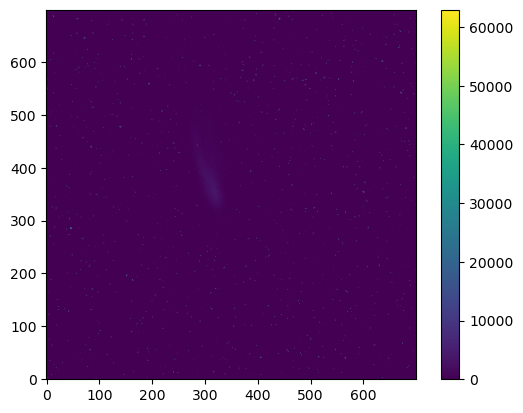

In [10]:
processed_image = image_processor.process(raw_image)